# The double integrator example: the permanent case

## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min T, \\[0.5em]
        \dot{x}_1(t) = x_2(t) \\
        \dot{x}_2(t) = u(t), \quad u(t) \in [-1, 1],   \\[0.5em]
        x(0) = x_0,\quad x(T) = 0_{\mathrm{R}^2}.
    \end{array}
    \right.
$$

In [1]:
# For direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving
# To plot solutions
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct DirectSolution
    t; x1; x2; u; p1; p2
end

In [3]:
# Parameters
t0  = 0.    # initial time
x1f = 0.    # Final position
x2f = 0.
M   = 1.0;   # control bound

### Direct method

In [4]:
function DI(x0; solution=[], nsteps=200, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-8)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-8)
    set_optimizer_attribute(sys,"max_iter",1000)

    N  = nsteps     # Grid size

    @variables(sys, begin
        x1[1:N+1]    # x1
        x2[1:N+1]    # x2
        -M ≤ u[1:N+1] ≤ M    # Control
        0. ≤ Δt ≤ 1. # contraints may be "superflues"
    end)

    # Objective
    @objective(sys, Min, Δt)

    # Boundary constraints
    @constraints(sys, begin
        con_x10, x1[1] - x0[1] == 0
        con_x20, x2[1] - x0[2] == 0
        con_x1f, x1[N+1] - x1f == 0
        con_x2f, x2[N+1] - x2f == 0
    end)

    # Dynamics
    @NLexpression(sys, dx1[j = 1:N+1], x2[j])
    @NLexpression(sys, dx2[j = 1:N+1],  u[j])

    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dx1[j=1:N], x1[j+1] == x1[j] + 0.5 * Δt * (dx1[j+1] + dx1[j])
        con_dx2[j=1:N], x2[j+1] == x2[j] + 0.5 * Δt * (dx2[j+1] + dx2[j])
    end);

    # Pas super utile
    if solution == [] # initialisation
#        for i in 1:N+1
#           set_start_value(x1[i], -0.5);
#           set_start_value(x2[i],  0.0);
#           set_start_value(u[i],   0.);
#           set_start_value(Δt,     1.0/N);
#        end
        else # ne fonctionne que si on garde le même nombre de pas
        for i in 1:N+1
            set_start_value(x1[i],  solution.x1[i]);
            set_start_value(x2[i],  solution.x2[i]);
            set_start_value(u[i],   solution.u[i]);
            set_start_value(Δt,     solution.t[end]/N);
        end
    end

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values (including duals)
    x1 = value.(x1)[:]
    x2 = value.(x2)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)

    px10 = dual(con_x10)
    px20 = dual(con_x20)
    px1f = dual(con_x1f)
    px2f = dual(con_x2f)

    if(px10*dual(con_dx1[1])<0); px10 = -px10; end
    if(px20*dual(con_dx2[1])<0); px20 = -px20; end
    if(px1f*dual(con_dx1[N])<0); px1f = -px1f; end
    if(px2f*dual(con_dx2[N])<0); px2f = -px2f; end

    # H = px1 * x2 + px2 * u > 0, according to Pontryagin Maximum Principle convention
    if (px10 * x2[1] + px20 * u[1] < 0) 
        sign = -1.0 # switch sign of dual variables
    else
        sign =  1.0
    end

    px1 = [ dual(con_dx1[i]) for i in 1:N ]
    px2 = [ dual(con_dx2[i]) for i in 1:N ]

#    px1 = sign * [px10; (px1[1:N-1]+px1[2:N])/2.; px1f]; # We add the multiplier from the limit conditions
#    px2 = sign * [px20; (px2[1:N-1]+px2[2:N])/2.; px2f]; # We add the multiplier from the limit conditions

    p1 = sign * [px10; px1[1:N-1]; px1f]; # We add the multiplier from the limit conditions
    p2 = sign * [px20; px2[1:N-1]; px2f]; # We add the multiplier from the limit conditions

    return DirectSolution(t, x1, x2, u, p1, p2)
    
end;

In [5]:
# Resolution
x0_ref  = [-1.; 0.]
direct_sol = DI(x0_ref);

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2004
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2400

Total number of variables............................:      604
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      202
                     variables with only upper bounds:        0
Total number of equality constraints.................:      404
Total number of in

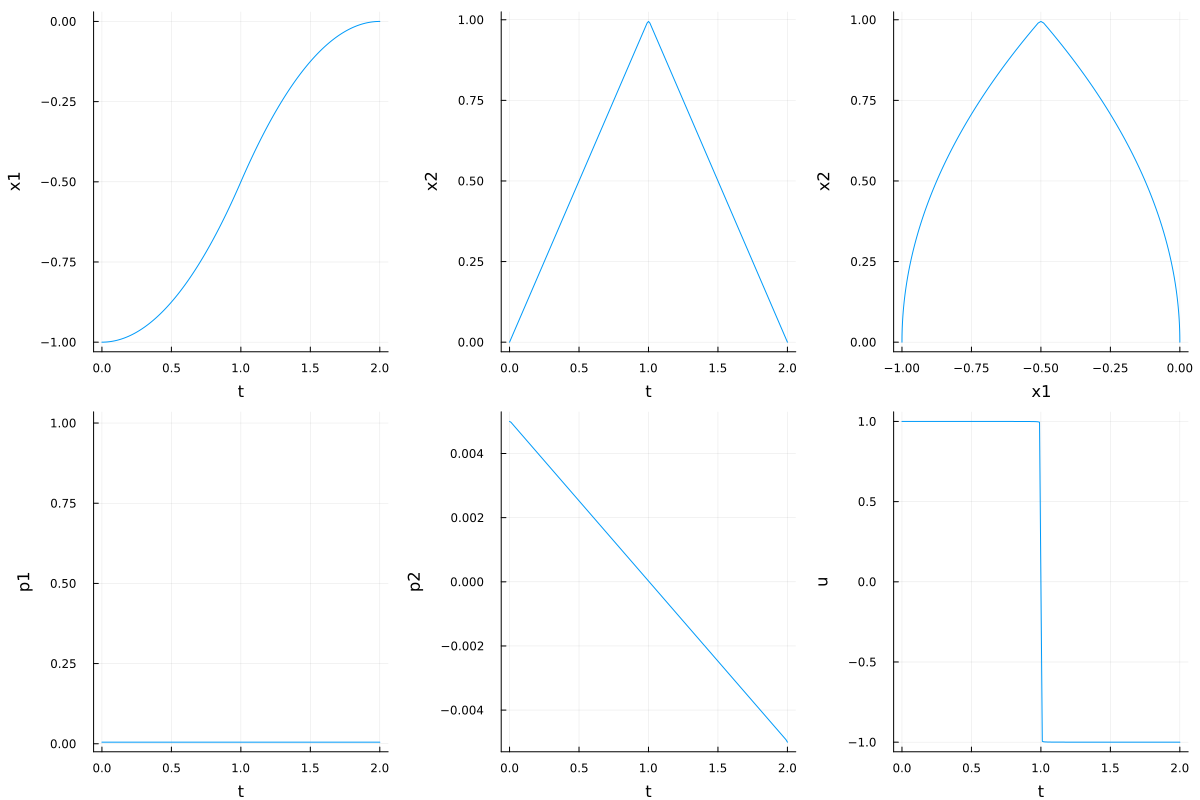

In [7]:
# Plots
t  = direct_sol.t
x1 = direct_sol.x1
x2 = direct_sol.x2
u  = direct_sol.u
p1 = direct_sol.p1
p2 = direct_sol.p2

x1_plot   = plot(t, x1,  xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t, x2,  xlabel = "t", ylabel = "x2",  legend = false)
p1_plot  = plot(t, p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot  = plot(t, p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, p1_plot, p2_plot, u_plot, layout = (2,3), size=(1200,800), left_margin=5mm)

### Indirect method

In [8]:
using NLsolve
include("flow.jl");

In [9]:
# Dynamics
function F0(x)
    return [ x[2], 0.0 ]
end

function F1(x)
    return [ 0., 1. ]
end

# Hamiltonians and associated flows
H0(x, p) = p' * F0(x)
H1(x, p) = p' * F1(x)

H(x, p, u) = H0(x, p) + u*H1(x,p) # pseudo-Hamiltonian

up(x, p) =  M
um(x, p) = -M

Hp(x, p) = H(x, p, up(x, p))
Hm(x, p) = H(x, p, um(x, p))


fp = Flow(Hp)
fm = Flow(Hm);

In [10]:
# Shooting function
function shootBpBm(p0, t1, T, x0) # B+ B- structure
    
    x1, p1 = fp(t0, x0, p0, t1)
    xT, pT = fm(t1, x1, p1, T)
    
    s = zeros(eltype(p0), 4)
    
    s[1:2] = xT - [ x1f, x2f ] # target
    
    s[3] = H1(x1, p1) # switching
    s[4] = Hp(x0, p0) - 1. # free final time

    return s

end;

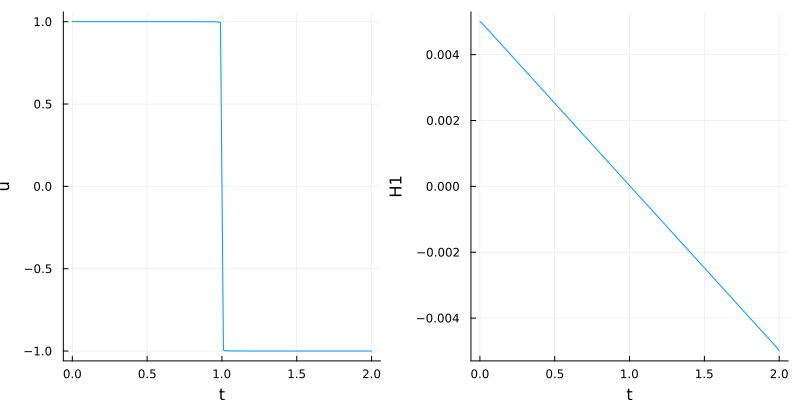

Initial guess:
[0.0050003742784395875, 0.005000749825276898, 1.0000751037466158, 2.0001502074932316]


In [11]:
# Initialisation
m = length(t)
x = [ [  x1[i],  x2[i] ] for i in 1:m ]
p = [ [  p1[i],  p2[i] ] for i in 1:m ];
H1s = H1.(x, p)

H1_plot = plot(t, H1s, xlabel = "t", ylabel = "H1", legend = false)

display(plot(u_plot, H1_plot, layout = (1,2), size=(800,400)))

it1 = findall(H1s[2:m].*H1s[1:m-1].<0.)
if length(it1)==1
    it1 = it1[1]
else
    error("Should have only one switch")
end

p0 = p[1]
t1 = t[it1]
T  = t[end]
ξ  = [ p0 ; t1 ; T ]
println("Initial guess:\n", ξ)

In [12]:
# Solve
S(ξ) = shootBpBm(ξ[1:2], ξ[3], ξ[4], x0_ref)

println("Initial value of shooting:\n", S(ξ), "\n\n")

indirect_sol = nlsolve(S, ξ; xtol=1e-8, method=:trust_region, show_trace=true)
println(indirect_sol)

# Retrieves solution
if indirect_sol.f_converged || indirect_sol.x_converged
    p0 = indirect_sol.zero[1:2]
    t1 = indirect_sol.zero[3]
    T  = indirect_sol.zero[4]
else
    error("Not converged")
end;

Initial value of shooting:
[0.00015021313380379186, 1.4683691446049388e-18, -5.48070129880002e-15, -0.9949992501747231]


Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     9.949993e-01              NaN
     1     7.471977e-05     1.407089e+00
     2     2.101533e-13     7.472260e-05
Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.0050003742784395875, 0.005000749825276898, 1.0000751037466158, 2.0001502074932316]
 * Zero: [0.9999999999997903, 1.0, 0.9999999999999998, 2.0000000000000013]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 1.0e-08: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3


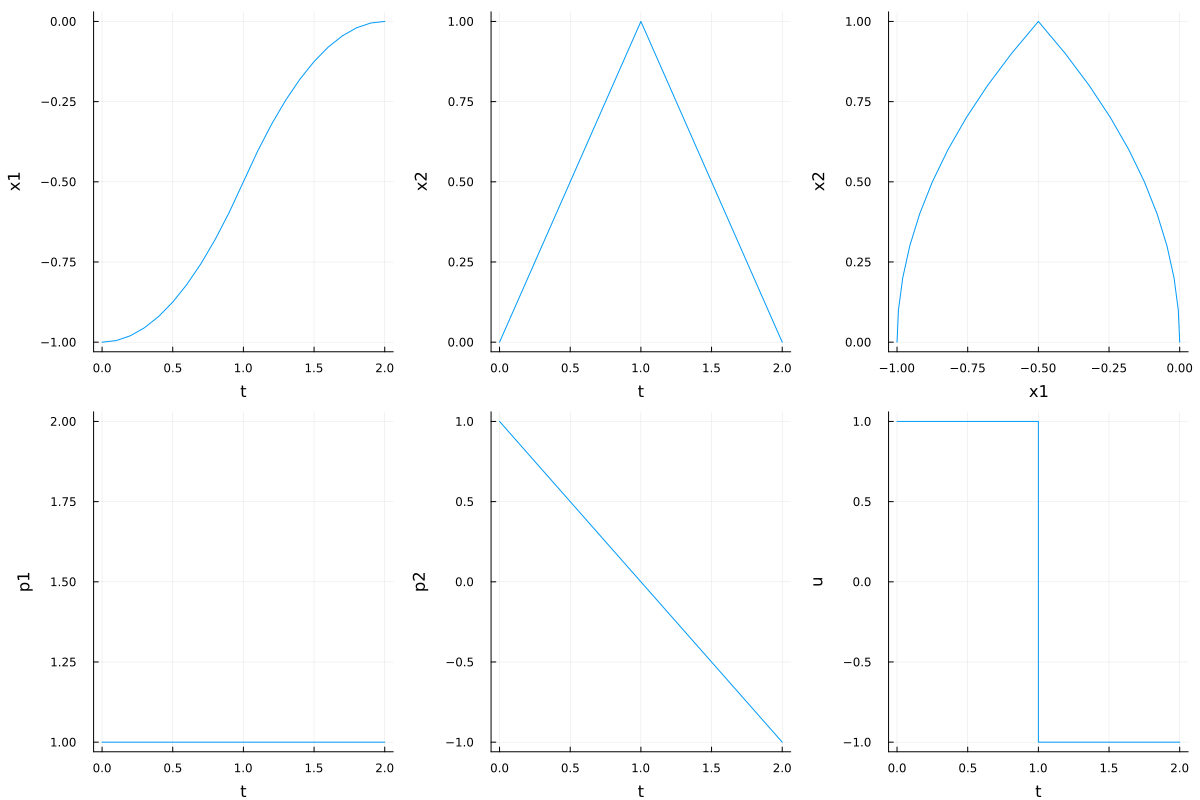

In [13]:
# plots

ode_sol = fp((t0, t1), x0_ref, p0, saveat=0.1)

tt1 = ode_sol.t
xx1 = [ ode_sol[1:2, j] for j in 1:size(tt1, 1) ]
pp1 = [ ode_sol[3:4, j] for j in 1:size(tt1, 1) ]
uu1 = up.(xx1, pp1)

ode_sol = fm((t1, T), xx1[end], pp1[end], saveat=0.1)

tt2 = ode_sol.t
xx2 = [ ode_sol[1:2, j] for j in 1:size(tt2, 1) ]
pp2 = [ ode_sol[3:4, j] for j in 1:size(tt2, 1) ]
uu2 = um.(xx2, pp2)

t = [tt1; tt2]
x = [ xx1 ; xx2 ]
p = [ pp1 ; pp2 ]
u = [ uu1 ; uu2 ]

m = length(t)
x1 = [ x[i][1] for i=1:m ]
x2 = [ x[i][2] for i=1:m ]
p1 = [ p[i][1] for i=1:m ]
p2 = [ p[i][2] for i=1:m ];

x1_plot   = plot(t,  x1, xlabel = "t", ylabel = "x1",  legend = false)
x2_plot   = plot(t,  x2, xlabel = "t", ylabel = "x2",  legend = false)
p1_plot   = plot(t,  p1, xlabel = "t", ylabel = "p1", legend = false)
p2_plot   = plot(t,  p2, xlabel = "t", ylabel = "p2", legend = false)
u_plot    = plot(t,   u, xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)
x1x2_plot = plot(x1, x2, xlabel = "x1", ylabel = "x2",  legend = false)

plot(x1_plot, x2_plot, x1x2_plot, p1_plot, p2_plot, u_plot, layout = (2,3), size=(1200,800), left_margin=5mm)